<div style="background-color: yellow; padding: 18px;">
    <h1> Data Science Challenge |  Data & Analytics Team
</div>

<div style="background-color: lightblue; padding: 10px;">
    <h2> Case 2 - Similitud entre productos
</div>
    

**Descripción**
 
Un desafío constante en MELI es el de poder agrupar productos similares utilizando algunos atributos de estos como pueden ser el título, la descripción o su imagen.
Para este desafío tenemos un dataset “items_titles.csv” que tiene títulos de 30 mil productos de 3 categorías diferentes de Mercado Libre Brasilultados de ofertas del tipo relampago para un periodo de tiempo y un país determinado.

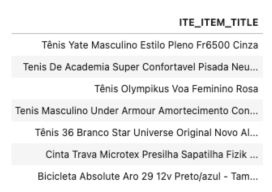

   
El objetivo del desafío es poder generar una Jupyter notebook que determine cuán similares son dos títulos del dataset “item_titles_test.csv” generando como output un listado de la forma donde ordenando por score de similitud podamos encontrar los pares de productos más similares en nuestro dataset de test.
    
___

# Estratégia adotada:

- Usar product similarity with text embedding (LaBSE)
-
-
-
-
-

## Contexto do problema

O título das publicações dos items são escritos pelos sellers e, muitas vezes se referem a produtos idênticos. Entender melhor o produto anunciado ajuda em diversos fluxos como, por exemplo:
- Sugerir um domínio para aquele produto (segmento)
- identificar se o produto é hazmat evitando acidentes nas operações (bateria, aerosol, ácidos entre outros)
- se é permitido o armazenamento em Fulfilments, em qual centro de distribuição devido ao tamanho (bulk, se é touchtable) e como armazenar (se é de supermercado ou alto valor tem que ficar separado).
- qual tipo de transporte ou manipulação deve ser feita; se pode passar por Meliair
- estimar as dimensões e pesos do item para calcular o frete, dimensionar área do caminhão, selecionar o tipo de caixa caso seja produto de fulfillment.

Enfim, identificar produtos similares pelo título do anúncio é de fundamental importância

In [1]:
import tensorflow_text # noqa
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd

In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

In [9]:
#gera embedding e aplica normalização l2

# Loading models from tfhub.dev
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1")
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang_preprocess/1")

# Constructing model to encode texts into high-dimensional vectors
sentences = tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentences")
encoder_inputs = preprocessor(sentences)
sentence_representation = encoder(encoder_inputs)["pooled_output"]
normalized_sentence_representation = tf.nn.l2_normalize(sentence_representation, axis=-1)  # for cosine similarity
model = tf.keras.Model(sentences, normalized_sentence_representation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentences (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['sentences[0][0]']              
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [11]:
product_df = pd.read_csv('files/items_titles.csv')

product_data = product_df['ITE_ITEM_TITLE'].values

product_embedding_data = model.predict(product_data)

product_embedding_data_df = pd.DataFrame(product_embedding_data)

product_embedding_data_df['ITE_ITEM_TITLE'] = product_df['ITE_ITEM_TITLE']

product_embedding_data_df.to_csv('output/items_titles_embedding.csv', index=False)

938/938 [==============================] - 6543s 7s/step


In [8]:
df

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Vermelho
1,Tenis Para Caminhada Super Levinho Spider Corrida
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve
...,...
29995,Tênis Vans Old Skool I Love My Vans - Usado - Feminino
29996,Tênis Feminino Preto Moleca 5296155
29997,Tenis Botinha Com Pelo Via Marte Original Lançamento
29998,Tênis Slip On Feminino Masculino Original Sapato Xadrez Mule


In [13]:
# testa df
product_test_df = pd.read_csv('files/items_titles_test.csv')

product_test_data = product_test_df['ITE_ITEM_TITLE'].values

product_test_embedding_data = model.predict(product_test_data)

product_test_embedding_data_df = pd.DataFrame(product_test_embedding_data)

product_test_embedding_data_df['ITE_ITEM_TITLE'] = product_test_df['ITE_ITEM_TITLE']

313/313 [==============================] - 2227s 7s/step


In [16]:
product_test_embedding_data_df.to_csv('output/items_titles_test_embedding.csv', index=False)

In [17]:
product_test_embedding_data_df = pd.read_csv('output/items_titles_test_embedding.csv')

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
product_embedding = product_embedding_data_df.loc[:, product_embedding_data_df.columns != 'ITE_ITEM_TITLE']

In [20]:
product_test_embedding = product_test_embedding_data_df.loc[:, product_test_embedding_data_df.columns != 'ITE_ITEM_TITLE']

In [21]:
product_similarity = cosine_similarity(product_test_embedding, product_embedding)

In [22]:
product_similarity.shape

(10000, 30000)

In [23]:
products = product_embedding_data_df['ITE_ITEM_TITLE']
product_test = product_test_embedding_data_df['ITE_ITEM_TITLE']

In [ ]:
product_pairs = pd.DataFrame(index=pd.MultiIndex.from_product([product_test, products], names=['ITE_ITEM_TITLE_A', 'ITE_ITEM_TITLE_B']))
product_pairs['similarity'] = product_similarity.flatten()

# Reset the index to get product_a and product_b as columns
pairwise_df = product_pairs.reset_index()

In [26]:
del product_embedding_data_df